In [1]:
from configs.config import config
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # GPU No.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
from sampler.utils import *
from trainer.utils import restore_checkpoint
import torch
import torch.nn as nn
import scipy.io
import sys

from torch.utils.data import DataLoader
from tqdm import tqdm

from models.unet_video import UNetVideoModel
from models.ema import ExponentialMovingAverage
from sampler import VESDE
import numpy as np
from einops import rearrange

2024-04-29 19:08:38.149144: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 19:08:38.203966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 19:08:39.066970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load pretrained model

In [2]:
config.cuda = config.gpu is not None
if config.cuda:
    device = 'cuda'
else:
    device = 'cpu'

checkpoint_path = '/data/cylinder2d/checkpoint_ns4_cylinder2d_video_v0.pth'
scalar_path = '/data/cylinder2d/scalar_ns4_cylinder2d_video_v0.npy'
config.version = 'cylinder2d_video_v0'
config.num_samples_train = 100000
config.batch_size = 32
config.num_conditions = 1
config.num_frames = 10
config.num_components = 2
config.image_size = 64
config.dimension = config.image_size * (config.num_frames + config.num_conditions)
config.num_channels = config.num_components + config.num_conditions
config.channel_modal = [config.num_frames*config.num_components, 1]
config.num_modals = len(config.channel_modal)
net = UNetVideoModel(config.num_channels, model_channels=32, out_channels=config.num_channels, 
                        num_res_blocks=2, 
                        attention_resolutions=(8, 16), 
                        image_size=config.image_size, 
                        dropout=0.1, 
                        channel_mult=(1, 2, 4, 8),
                        conv_resample=True,
                        dims=2,
                        num_heads=1,
                        use_rpe_net=True)

net = nn.DataParallel(net)
net.to(device)
ema = ExponentialMovingAverage(net.parameters(), decay=config.ema_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
state = dict(optimizer=optimizer, model=net, ema=ema, epoch=0, iteration=0)

state = restore_checkpoint(checkpoint_path, state, device)
net = state['model']
optimizer = state['optimizer']
ema = state['ema']

_, z = np.meshgrid(np.linspace(0, 2 * np.pi, config.image_size, endpoint=False),
                    np.linspace(0, 2 * np.pi, config.image_size, endpoint=False), indexing='ij')

mean, std = np.load(scalar_path)
scalar = lambda x: (x-mean)/std
scalar_inv = lambda x: x*std+mean

# Load experimental data from PIV

In [3]:
vel_c = 1600    # 1100, 1600, 2500 are provided

from einops import rearrange
is_avg = False
dt_c = 1./80
dia_c = 6e-3     # 5.28e-3
T_c = 20.0

measures = np.load(f'/data/cylinder2d/{vel_c}/piv_vel_test.npy')       # _filtered
grid = np.load(f'/data/cylinder2d/{vel_c}/piv_grid.npy')/dia_c
ny, nx = measures.shape[-2:]
vel_c = vel_c/1000/60
measures = measures/vel_c*0.1
Re_c = vel_c*dia_c/cal_water_attr(T_c)['nu']
para = 0.1/Re_c*1000
cs = [2., 3., 4., 6.]       # cross sections
coords = []
for i in cs:
    coord = np.zeros([grid.shape[-2], 2])
    coord[:, 0] = i
    coord[:, 1] = grid[1, :, 0]
    coords.append(coord)
coords = np.concatenate(coords, axis=0)
spacing_m = coords[1, 1]-coords[0, 1]
# offsets_m = np.array([-0.5, 32./2*spacing_m])
offsets_m = np.array([-grid[0, 0, 0], ny/2*spacing_m])
y = sample_to_hot_wire(rearrange(torch.from_numpy(measures), 't c h w -> () (t c) w h'), coords, spacing=spacing_m, offsets=offsets_m, is_avg=is_avg,
                                                num_frame=len(measures)*2,
                                                scalar=None,
                                                use_para=False, weight=1.).numpy()
print(measures.shape, y.shape, Re_c)

(879, 2, 50, 67) (1, 879, 200) 159.0457256461233


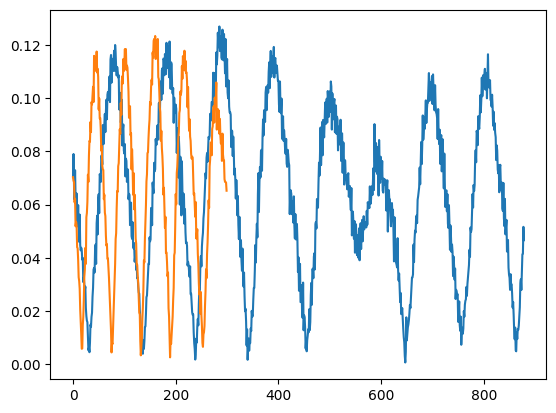

(1, 55, 50) 0.5555555555555556


In [4]:
%matplotlib inline
config.overlap = 1
config.num_steps = 50

from scipy.interpolate import interp1d
nf = config.num_frames
ns = config.num_steps
ol = config.overlap
b = int(ns // (nf - ol) + 1)  # the number of samples that need to generate
ns_real = b * (nf - ol) + ol

config.channel_modal = None

weight = 0.05
use_para = False
start_frame = 20
obs_pos = np.arange(ny)[:]     # np.arange(ny)[:]
dt = dt_c/(dia_c/(vel_c/0.1))
para_obs = (para*np.sin(4*z))[np.newaxis].repeat(len(y), axis=0)
if not is_avg:
    y_interp = []
    for i in range(y.shape[-1]):
        f = interp1d(np.arange(y.shape[-2])*dt, y[0, :, i], kind='linear')
        y_interp.append(f(np.arange(300)))
    y_interp = np.stack(y_interp, axis=-1)[np.newaxis]
    fig, ax = plt.subplots()
    ax.plot(y[0, :, 30])
    ax.plot(y_interp[0, :, 30])
    plt.show()
    # fig.savefig('./results/test_line.pdf')
    y0 = y_interp[:, start_frame:start_frame+ns_real]
else:
    y0 = y.copy()
y = np.concatenate([y0[..., obs_pos].reshape(len(y0), -1), weight*para_obs.reshape(len(y), -1)], axis=-1) if use_para else y0[..., obs_pos]
dt_ratio = dt/1.0
print(y.shape, dt_ratio)

# Reconstruction

In [13]:
outer_loop = 200
inner_loop = 5
seed_sample = 666    # performance is affected by the noise added to the sampling path

# guidance coefficients (may vary for different samples)
alpha = 600      # observation guidance
gamma1 = 1   # sequence consistency guidance
gamma2 = 1   # parameter consistency guidance

'''for flow behind the cylinder'''
u0 = 0.1
spacing = 2 * np.pi / 64
offsets = np.array([-0.5, spacing * 32])
sde = VESDE(config, sigma_min=config.beta_min, sigma_max=config.beta_max, N=outer_loop)
net.eval()
reap_fn = lambda x, num: torch.stack([x for _ in range(num)])
latent_mask = torch.stack([torch.ones([config.num_frames, 1, 1, 1]).float() for _ in range(len(y))]).to(device)
obs_mask = torch.stack([torch.zeros([config.num_frames, 1, 1, 1]).float() for _ in range(len(y))]).to(device)
frame_indices = torch.stack([torch.arange(config.num_frames) for _ in range(len(y))]).to(device)
latent_mask = torch.ones([config.num_frames, 1, 1, 1]).float().to(device)
obs_mask = torch.zeros([config.num_frames, 1, 1, 1]).float().to(device)
frame_indices = torch.arange(config.num_frames).to(device)
net_fn = lambda x, t: net(x, x0=x, timesteps=t, latent_mask=reap_fn(latent_mask, len(x)), obs_mask=reap_fn(obs_mask, len(x)), frame_indices=reap_fn(frame_indices, len(x)))[0]

setup_seed(seed_sample)
with torch.no_grad():

    # transform = lambda xx: mask_torch[None, ..., None] * sample_to_vel(xx, ns_real, scalar=scalar)
    transform_gen = lambda xx: sample_to_hot_wire(xx, coords[obs_pos], spacing, offsets=offsets, is_avg=is_avg,
                                                num_frame=config.num_components,
                                                scalar=scalar_inv,
                                                use_para=use_para, weight=weight)
    # y_gen = y[..., :32*3]
    transform = lambda xx: sample_to_hot_wire(xx, coords, spacing, offsets=offsets, is_avg=is_avg,
                                                num_frame=config.num_components,
                                                scalar=scalar_inv,
                                                use_para=False, weight=weight)
    # transform = lambda xx: mask_torch*xx[:, :-config.num_conditions]
    # transform = lambda xx: mask_torch*xx
    # transform_gen = lambda xx: xx[:, :1, config.num_components:]        # para conditioned
    # y = 0.1/1000*1000*np.ones_like(z)[np.newaxis, np.newaxis, np.newaxis].repeat(config.num_samples, axis=0)

    x_inpainted, _ = complete_video_pc_dps(config, net_fn, sde, y,
                                                        transform_gen,
                                                        alpha=alpha, beta=0, gamma1=gamma1, gamma2=gamma2,
                                                        corrector=LangevinCorrector,
                                                        snr=0.128, save_sample_path=False,
                                                        n_steps=inner_loop,
                                                        device=device, dtype='float', eps=1e-12,
                                                        probability_flow=False, continuous=True,
                                                        data_scalar=scalar)
x_pred = x_inpainted

100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


# Aligned the grids of generated field with experimental data

In [14]:
from scipy.interpolate import interp2d
scalar = lambda x: (x-mean)/std
scalar_inv = lambda x: x*std+mean
start_ori = start_frame/dt_ratio
end_ori = (start_frame+ns_real)/dt_ratio
print(start_ori, end_ori)

xx = yy = np.linspace(0, 2*np.pi, config.image_size)
xx = xx-offsets[0]+spacing/2
yy = yy-offsets[1]
grid_gen = np.stack(np.meshgrid(xx, yy))
x_inter = np.array([max(grid_gen[0].min(), grid[0].min()), min(grid_gen[0].max(), grid[0].max())])
y_inter = np.array([max(grid_gen[1].min(), grid[1].min()), min(grid_gen[1].max(), grid[1].max())])
print(grid_gen[0].min(), grid[0].min(), f'x_min = {max(grid_gen[0].min(), grid[0].min())}')
print(grid_gen[0].max(), grid[0].max(), f'x_max = {min(grid_gen[0].max(), grid[0].max())}')
print(grid_gen[1].min(), grid[1].min(), f'y_min = {max(grid_gen[1].min(), grid[1].min())}')
print(grid_gen[1].max(), grid[1].max(), f'y_max = {min(grid_gen[1].max(), grid[1].max())}')
indx_inter = [int((x_inter[0]-grid[0].min())//spacing_m), int((x_inter[1]-grid[0].min())//spacing_m)+1]
indy_inter = [int((y_inter[0]-grid[1].min())//spacing_m), int((y_inter[1]-grid[1].min())//spacing_m)+1]
print(indx_inter, indy_inter, grid.shape)
grid_inter = grid[:, indy_inter[0]:indy_inter[1], indx_inter[0]:indx_inter[1]]
print(measures.shape, grid_inter.shape)
pred_inter = []
ref_inter = []
for i in range(len(x_pred[0])):
    fu = interp2d(grid_gen[1, :, 0], grid_gen[0, 0], x_pred[0, i, 0], kind='cubic')
    fv = interp2d(grid_gen[1, :, 0], grid_gen[0, 0], x_pred[0, i, 1], kind='cubic')
    pred_inter.append(np.stack([scalar_inv(fu(grid_inter[1, :, 0], grid_inter[0, 0])).T, scalar_inv(fv(grid_inter[1, :, 0], grid_inter[0, 0])).T]))
    ref_inter.append(-measures[int(start_ori+i/dt_ratio), :, indy_inter[0]:indy_inter[1], indx_inter[0]:indx_inter[1]])
pred_inter = np.array(pred_inter)
ref_inter = np.array(ref_inter)

36.0 135.0
0.5490873852123406 0.8910109865322975 x_min = 0.8910109865322975
6.832272692391927 7.772804349500739 x_max = 6.832272692391927
-3.141592653589793 -2.606739910215319 y_min = -2.606739910215319
3.141592653589793 2.502470313806706 y_max = 2.502470313806706
[0, 57] [0, 50] (2, 50, 67)
(879, 2, 50, 67) (2, 50, 57)


/tmp/ipykernel_2407/3389299581.py:26: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  fu = interp2d(grid_gen[1, :, 0], grid_gen[0, 0], x_pred[0, i, 0], kind='cubic')
/tmp/ipykernel_2407/3389299581.py:27: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridIn

# Visualization

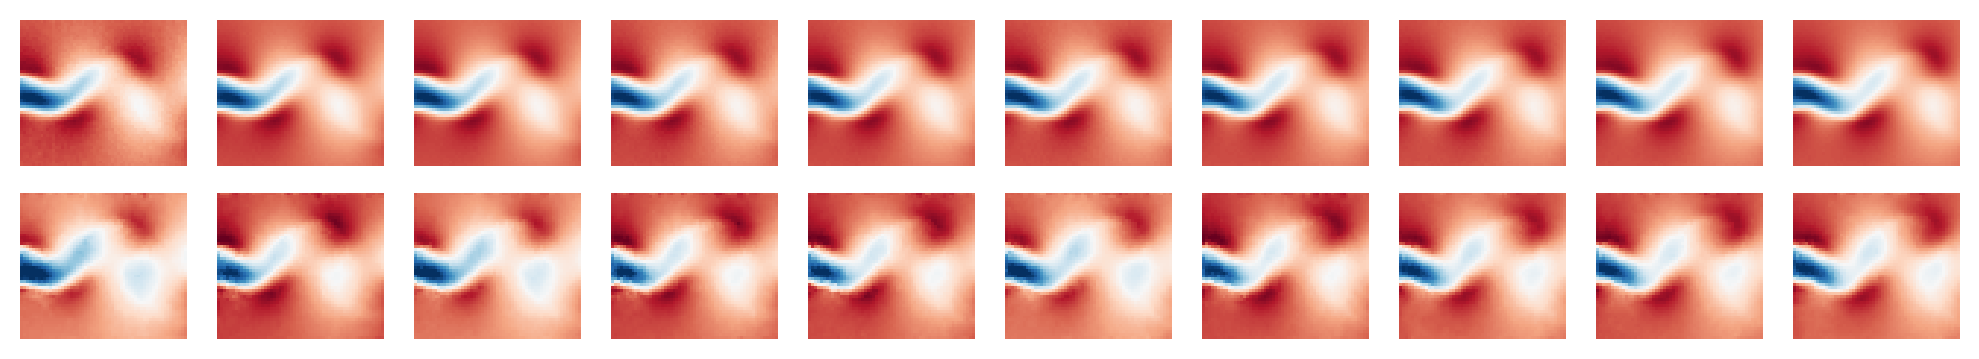

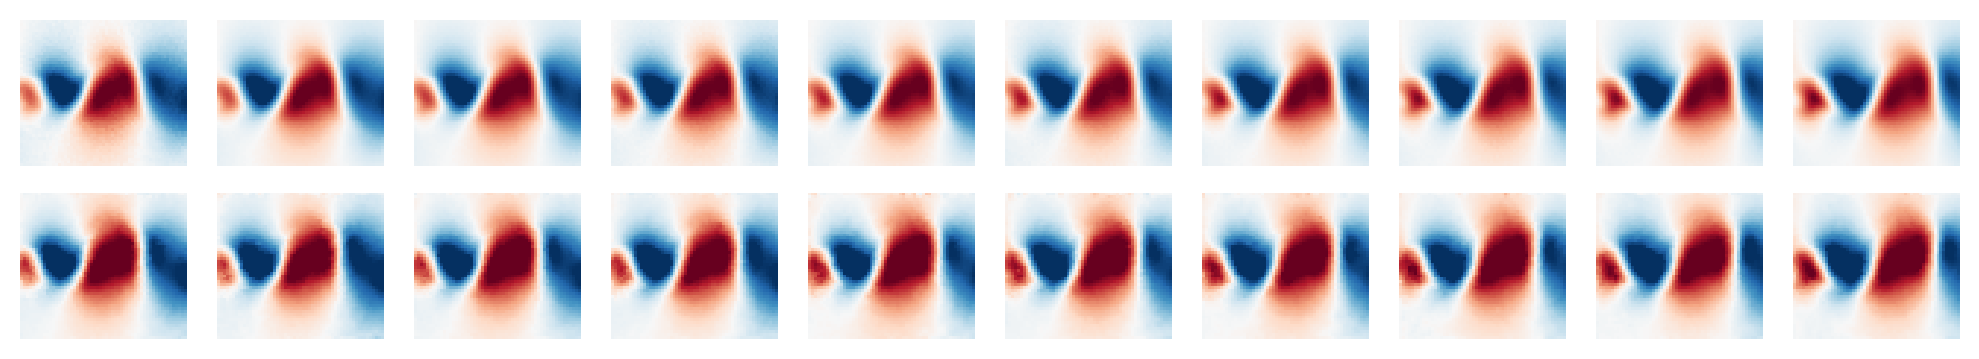

In [15]:
from einops import rearrange
i_start = 20
length  = 10
plot_field(np.concatenate([pred_inter[i_start:i_start+length, 0], ref_inter[i_start:i_start+length, 0]]), 2, length, dpi=200, q_range=[-0.02, 0.13])  # 1st component of velocity
plot_field(np.concatenate([pred_inter[i_start:i_start+length, 1], ref_inter[i_start:i_start+length, 1]]), 2, length, dpi=200, q_range=[-0.05, 0.05])  # 2nd component of velocity

# GIF of the generated field
Please check './results/test_cy.gif' for the generated GIF!

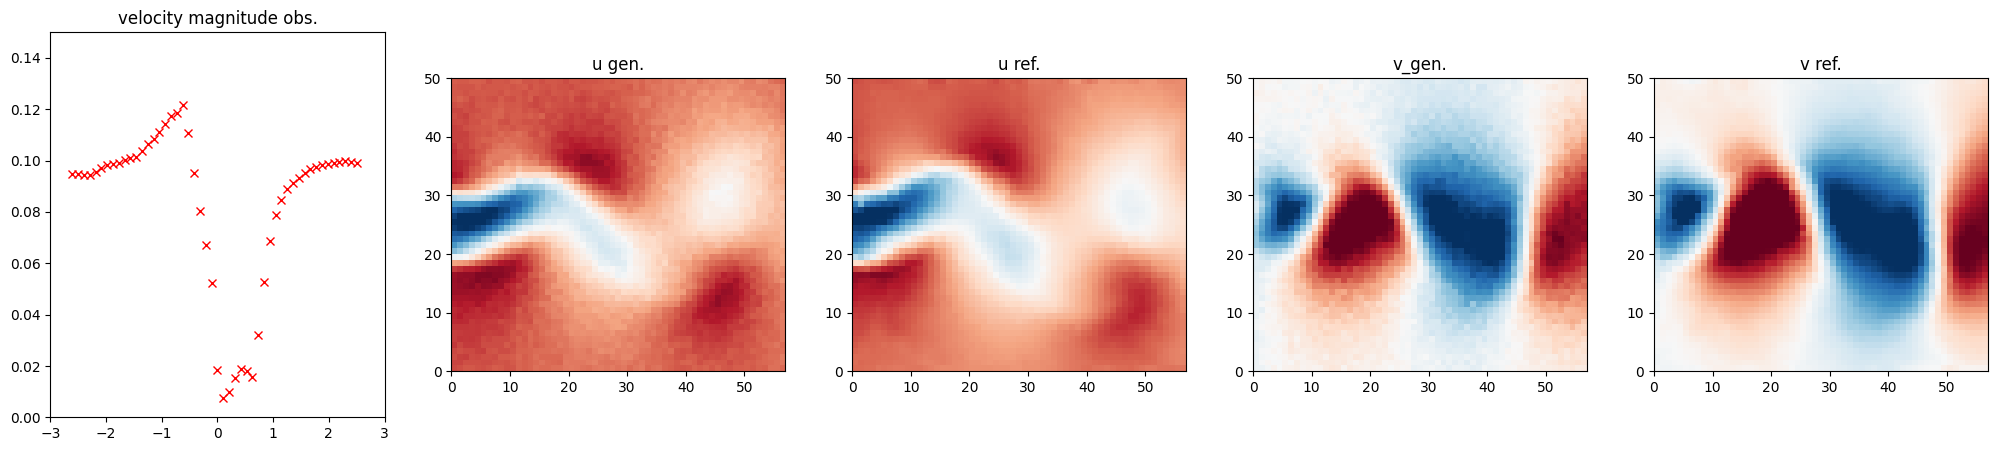

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

data_plot = [y[0], pred_inter[:, 0], ref_inter[:, 0], pred_inter[:, 1], ref_inter[:, 1]]       # y[0, :, 0], vor_cal_batch(np.concatenate([samples_noise[0, :, 1:2], samples_noise[0, :, :1]], axis=1), config.image_size, [0, domain_size]), 
data_title = ['velocity magnitude obs.', 'u gen.', 'u ref.', 'v_gen.', 'v ref.']   # 'obs.', 
vmins = [0, -0.02, -0.02, -0.05, -0.05]    # -3, 
vmaxs = [0.15, 0.13, 0.13, 0.05, 0.05]      # 3, 
n_plot = len(data_plot)
def update(frame):
    plt.clf()  # Clear the current plot

    for i in range(n_plot):
        # Plot the first subplot
        plt.subplot(1, n_plot, i+1)
        if i==0:
            plt.plot(grid[1, :, 0], data_plot[0][frame], marker='x', color='r', label='ref.', linewidth=0)
            plt.gca().set_xlim([-3, 3])
            plt.gca().set_ylim([0, 0.15])
        else:
            plt.pcolormesh(data_plot[i][frame], cmap='RdBu_r', vmin=vmins[i], vmax=vmaxs[i])
            plt.gca().set_aspect(1)
        plt.title(data_title[i])

fig = plt.figure(figsize=(5*n_plot, 5))
ani = FuncAnimation(fig, update, frames=range(ns_real), repeat=False)
ani.save('/results/test_cy.gif', writer='pillow', fps=20)
